# Unsupvervised Learning

Clustering is a class of unsupervised learning methods that associates observations according to some specified measure of **similarity** (e.g. Euclidean distance).

## K-means Algorithm

The K-means clustering algorithm associates each point $x_i$ in a set of input points $\{x_1, x_2, \ldots, x_m\}$ to $K$ clusters. Each cluster is specified by a **centroid** that is the average location of all the points in the cluster. The algorithm proceeds iteratively from arbitrary centroid locations, updating the membership of each point according to minimum distance, then updating the centroid location based on the new cluster membership. 

You might notice that this is just a special case of the **expectation maximization (EM)** algorithm. Recall that in EM we iteratively assigned labels to observations, according to which mixture component they were most likely to have been derived from. K-means is simpler, in that we just use the minimum distance to assign membership.

The algorithm will have converged when the assignment of points to centroids does not change with each iteration.

### Algorithm

1. Initialize cluster centroids:

$$\mu^{(0)}_1, \ldots, \mu^{(0)}_k \in \mathbb{R}^n$$

2. Iterate until converged:

    a. Set $c_i = \text{argmin}_j || x_i - \mu_j^{(s)} ||$
    
    b. Update centroids:
    
    $$\mu_j^{(s+1)} = \frac{\sum_{i=1}^m I[c_i = j] x_i}{\sum_{i=1}^m I[c_i = j]}$$

The K-means algorithm is simply a Gaussian mixture model with two restrictions: 

1. the covariance matrix is spherical: 

    $$\Sigma_k = \sigma I_D$$

2. the mixture weights are fixed:

    $$\pi_k = \frac{1}{K}$$

Hence, we are only interested in locating the appropriate centroid of the clusters. This serves to speed computation.

We can define the distortion function:

$$J(c,\mu) = \sum_{i]1}^m ||x_i - \mu_{c_i}||$$

which gets smaller at every iteration. So, k-means is coordinate ascent on $J(c,\mu)$

### Choosing $k$

To check whether a chosen $k$ is reasonable, one approach is to compare the distances between the centroids to the mean distance bewween each data point and their assigned centroid. A good fit involves relatively large inter-centroid distances. 

The appropriate value for k (the number of clusters) may depend on the goals of the analysis, or it may be chosen algorithmically, using an optimization procedure.

## Example: clustering random points

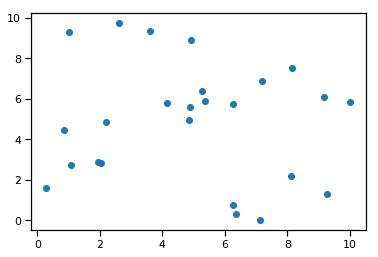

In [1]:
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
import numpy as np
import matplotlib.pyplot as plt

x, y = np.random.uniform(0, 10, 50).reshape(2, 25)
plt.scatter(x, y)

Let's start with $k=4$, arbitrarily assigned:

In [2]:
centroids = (3, 3), (3, 7), (7, 3), (7, 7)

In [3]:
np.transpose(centroids)

array([[3, 3, 7, 7],
       [3, 7, 3, 7]])

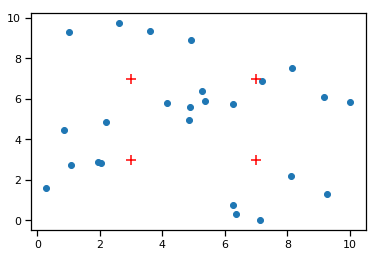

In [4]:
plt.scatter(x, y)
plt.scatter(*np.transpose(centroids), c='r', marker='+', s=100)

We can use the function `cdist` from SciPy to calculate the distances from each point to each centroid.

In [5]:
from scipy.spatial.distance import cdist

distances = cdist(centroids, list(zip(x,y)))
distances.shape

(4, 25)

We can make the initial assignment to centroids by picking the minimum distance.

In [6]:
labels = distances.argmin(axis=0)
labels

array([1, 1, 3, 3, 2, 3, 1, 1, 2, 0, 2, 3, 3, 0, 3, 1, 0, 0, 3, 2, 0, 1,
       0, 0, 2])

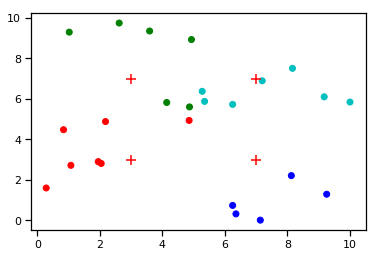

In [7]:
plt.scatter(x, y, c=np.array(list('rgbc'))[labels])
plt.scatter(*np.transpose(centroids), c='r', marker='+', s=100)

Now we can re-assign the centroid locations based on the means of the current members' locations.

In [8]:
new_centroids = [(x[labels==i].mean(), y[labels==i].mean())
                 for i in range(len(centroids))]

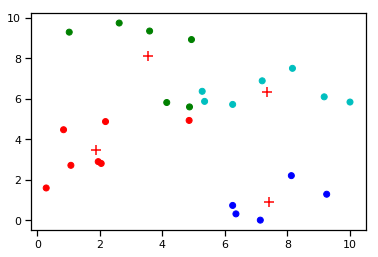

In [9]:
plt.scatter(x, y, c=np.array(list('rgbc'))[labels])
plt.scatter(*np.transpose(new_centroids), c='r', marker='+', s=100)

So, we simply iterate these steps until convergence.

In [10]:
centroids = new_centroids
iterations = 20

for _ in range(iterations):
    distances = cdist(centroids, list(zip(x,y)))
    labels = distances.argmin(axis=0)
    centroids = [(x[labels==i].mean(), y[labels==i].mean())
                 for i in range(len(centroids))]

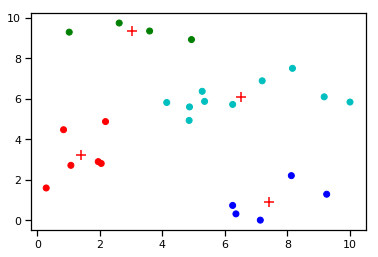

In [11]:
plt.scatter(x, y, c=np.array(list('rgbc'))[labels])
plt.scatter(*np.transpose(centroids), c='r', marker='+', s=100)

### Exercise

Re-run the model using different initial centroid locations, and compare the results.

## k-means using `scikit-learn`

The `scikit-learn` package includes a `KMeans` class for flexibly fitting K-means models. It includes additional features, such as initialization options and the ability to set the convergence tolerance.

In [12]:
from sklearn.cluster import KMeans
from numpy.random import RandomState
rng = RandomState(1)

# Instantiate model
kmeans = KMeans(n_clusters=4, random_state=rng)
# Fit model
kmeans.fit(np.transpose((x,y)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=<mtrand.RandomState object at 0x7f15939dfab0>, tol=0.0001,
    verbose=0)

After fitting, we can retrieve the labels and cluster centers.

In [13]:
kmeans.labels_

array([0, 3, 0, 0, 2, 0, 0, 3, 2, 0, 2, 0, 0, 1, 0, 3, 1, 1, 0, 2, 1, 3,
       1, 1, 2], dtype=int32)

In [14]:
kmeans.cluster_centers_

array([[6.52547761, 6.0702846 ],
       [1.3954452 , 3.23161671],
       [7.42137934, 0.91334162],
       [3.04033774, 9.33451617]])

The resulting plot should look very similar to the one we fit by hand.

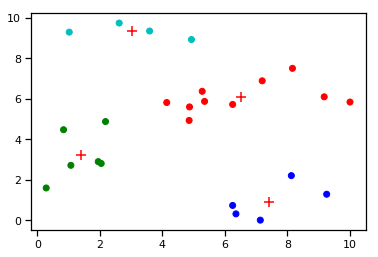

In [15]:
plt.scatter(x, y, c=np.array(list('rgbc'))[kmeans.labels_])
plt.scatter(*kmeans.cluster_centers_.T, c='r', marker='+', s=100)

## Example: Wine chemistry

Recall the wine dataset in `wine.dat` that includes thirteen chemical measurements carried out on each of 178 wines from three regions of Italy. If we did not have the labels for the wines, we might be interested to see whether a clustering algorithm could correctly assign labels to the wines.

In [16]:
import pandas as pd

wine = pd.read_table("../data/wine.dat", sep='\s+')

attributes = ['Grape',
            'Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']

wine.columns = attributes

wine.head()

,Grape,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,1.51,-0.56,0.23,-1.17,1.91,0.81,1.03,-0.66,1.22,0.25,0.36,1.84,1.01
1,1,0.25,-0.50,-0.83,-2.48,0.02,0.57,0.73,-0.82,-0.54,-0.29,0.40,1.11,0.96
2,1,0.20,0.02,1.11,-0.27,0.09,0.81,1.21,-0.50,2.13,0.27,0.32,0.79,1.39
3,1,1.69,-0.35,0.49,-0.81,0.93,2.48,1.46,-0.98,1.03,1.18,-0.43,1.18,2.33
4,1,0.29,0.23,1.84,0.45,1.28,0.81,0.66,0.23,0.40,-0.32,0.36,0.45,-0.04


In [17]:
X = wine.copy()
y = X.pop('Grape')

To simplify the analysis, and aid visualization, we will again perform a PCA to isolate the majority of the variation into two principal components.

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True).fit(X)
X_pca = pca.transform(X)

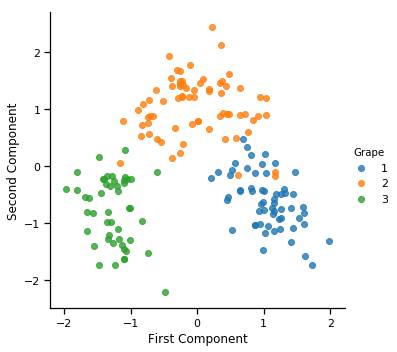

In [19]:
wine['First Component'] = X_pca[:, 0]
wine['Second Component'] = X_pca[:, 1]

sns.lmplot('First Component', 'Second Component', 
           data=wine, 
           fit_reg=False, 
           hue="Grape")

We can now create a `KMeans` object with `k=3`, and fit the data with it.

In [20]:
km_wine = KMeans(n_clusters=3, random_state=rng)
km_wine.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=<mtrand.RandomState object at 0x7f15939dfab0>, tol=0.0001,
    verbose=0)

From this, we can extract the cluster centroids (in the `cluster_center_` attribute) and the group labels (in `labels_`) in order to generate a plot of the classification result.

In [21]:
np.round(km_wine.cluster_centers_, decimals=2)

array([[-1.26, -0.77],
       [ 1.05, -0.61],
       [-0.04,  1.1 ]])

In [56]:
km_wine.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

Now we can visually examine the clusters, and compare them to the known labels.

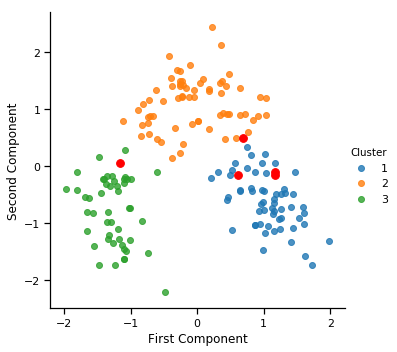

In [58]:
# Fix labels
np.place(km_wine.labels_, km_wine.labels_==0, 3)
wine['Cluster'] = km_wine.labels_

grid = sns.lmplot('First Component', 'Second Component', 
           data=wine, 
           fit_reg=False, 
           hue="Cluster")
grid.ax.scatter(*wine.loc[wine.Grape!=wine.Cluster, ['First Component', 'Second Component']].values.T, 
             s=60, linewidth=1, facecolors='none', c='r')

`scikit-learn` includes a suite of well-known clustering algorithms. 

- `sklearn.cluster.Birch`
: A memory-efficient, online-learning algorithm provided as an alternative to KMeans. It constructs a tree data structure with the cluster centroids being read off the leaf.
- `sklearn.cluster.MeanShift`
: Mean shift clustering aims to discover “blobs” in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids. But, mean shift is not scalable to high number of samples.
- `sklearn.cluster.DBSCAN`
: Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

## Exercise: clustering baseball statistics

We can use clustering to try to find interesting groupings among sets of baseball statistics. Load the baseball dataset and run a clustering algorithm on the set of three statistics:

* hit rate: hits / at bats
* strikeout rate: strikeouts / at bats
* walk rate: bases on balls /at bats

You should probably set a minimum number of at bats to qualify for the analysis, since there are pitchers that get only a handful of at bats each year.

Since we are clustering in 3 dimensions, you can visualize the output as a series of pairwise plots.

In [24]:
import pandas as pd

baseball = pd.read_csv("../data/baseball.csv", index_col=0)
baseball.head()

,player,year,stint,team,lg,g,ab,r,h,X2b,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,gidp
id,,,,,,,,,,,,,,,,,,,,,
88641,womacto01,2006,2,CHN,NL,19,50,6,14,1,...,2.0,1.0,1.0,4,4.0,0.0,0.0,3.0,0.0,0.0
88643,schilcu01,2006,1,BOS,AL,31,2,0,1,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
88645,myersmi01,2006,1,NYA,AL,62,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
88649,helliri01,2006,1,MIL,NL,20,3,0,0,0,...,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0
88650,johnsra05,2006,1,NYA,AL,33,6,0,1,0,...,0.0,0.0,0.0,0,4.0,0.0,0.0,0.0,0.0,0.0


In [25]:
## Write answer here

## DP-Means

The major weakness of the k-means approach to clustering is that the number of clusters needs to be specified at the outset. However, there is usually uncertainty with respect to the appropriate number of clusters for a given dataset. A flexible alternative to k-means that allows for an unknown number of clusters involves using a Bayesian non-parametric mixture model instead (Kulis and Jordan 2011). In particular, a Dirichlet process (DP) mixture model, which we have seen in a previous lecture, probabilistically assigns observations to clusters, using a stick-breaking algorithm. 

Recall the definition of a finite mixture model:

\\[f(y) = \sum_{h=1}^{k} \pi_h \mathcal{K}(y|\theta_h)\\]

where \\(k\\) is the number of mixture components, \\(\pi_h\\) is the mixing coefficient for component \\(h\\), and \\(K\\) specifies the mixing components (*e.g.* a Gaussian distribution), which has parameters \\(\theta_h\\) for each component. 

A DP mixture extends this by placing a Dirichlet prior of dimension \\(k\\) on the mixing coefficients. The distribution over the group indicators can then be specified as a categorical distribution:

\\[\begin{aligned}
\mathbf{\pi} &\sim \text{Dirichlet}(k, \pi_0) \\
z_1,\ldots,z_n &\sim \text{Categorical}(\mathbf{\pi}) \\
\end{aligned}\\]

We might then specify the observations as being a mixture of Gaussians, whose means are drawn from an appropriate prior distribution \\(P\\):

\\[\begin{aligned}
\theta_1,\ldots,\theta_k &\sim P \\
y_1,\ldots,y_n &\sim N(\theta_{z[i]}, \sigma I)
\end{aligned}\\]

To demonstrate, we will implement a DP to cluster the iris dataset.

In [26]:
from sklearn.decomposition import PCA
from sklearn import datasets

iris = datasets.load_iris()

pca = PCA(n_components=2, whiten=True).fit(iris.data)
X_pca = pca.transform(iris.data)
y = iris.target

The `sklearn.mixture` module includes a variety of Gaussian Mixture Models, including the `BayesianGaussianMixture` which fits the mixture using either Dirichlet distribution priors or Dirichlet process priors, and fits them using **variational inference**.

In [27]:
from sklearn.mixture import BayesianGaussianMixture

In [28]:
K = 10

dp_mixture = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_process", mean_precision_prior=1,
                n_components=K, reg_covar=0, init_params='random', weight_concentration_prior=1e5)

dp_mixture.fit(X_pca)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='random',
            max_iter=100, mean_precision_prior=1, mean_prior=None,
            n_components=10, n_init=1, random_state=None, reg_covar=0,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=100000.0,
            weight_concentration_prior_type='dirichlet_process')

In [29]:
from matplotlib import patches
import matplotlib.gridspec as gridspec

colors = np.array(['#0072B2', '#F0E442', '#D55E00'])

def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y):
    ax1.scatter(X[:, 0], X[:, 1], s=15, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_,
                  estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k - .45, w, width=0.9, color='#56B4E9', zorder=3)
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, K - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False,
                    right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    ax1.set_ylabel('Estimated Mixtures')
    ax2.set_ylabel('Weight of each component')

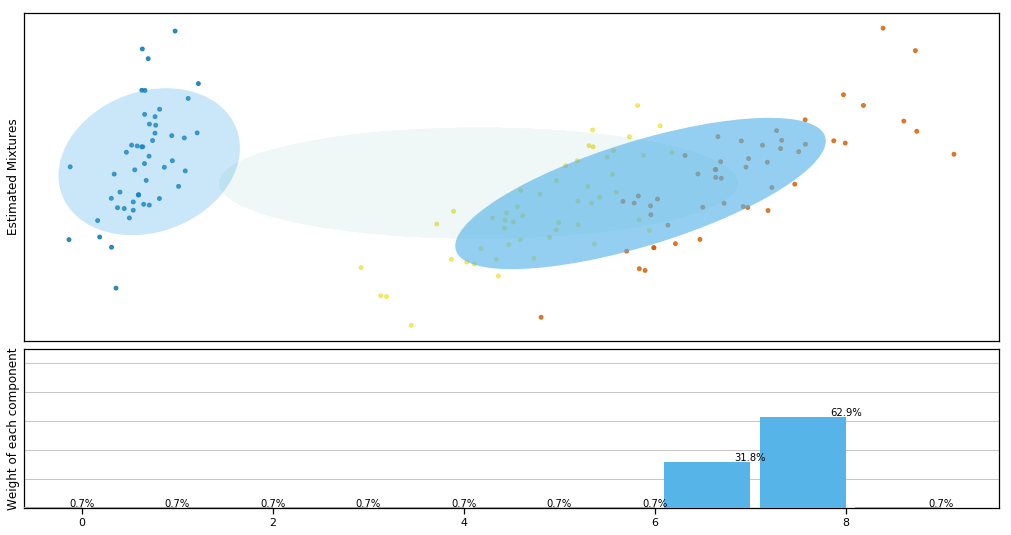

In [30]:
plt.figure(figsize=(4.7 * 3, 8))
plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                    left=.03, right=.99)

gs = gridspec.GridSpec(3, 1)
plot_results(plt.subplot(gs[:2]), plt.subplot(gs[2]), dp_mixture, X_pca, y)


As we have shown, the Dirichlet process mixture results in infinite mixture models which do not fix the number of clusters in the data *a priori*. However, Bayesian non-parametric models require fitting via sampling algorithms or variational inference techniques that are non-trivial to implement and scale poorly with large data. This is in contrast to k-means, which is straightforward to implement and scales easily.

It can be shown that the k-means algorithm is a limiting special case of the EM agorithm, if all of the covariance matrices associated with the clusters in a Gaussian mixture model set to $\sigma I$ and we let $\sigma$ go to zero. We can apply a similar limit to the Dirichlet process, using a Gibbs sampling algorithm. The result is a method with **hard** (rather than probabilistic) cluster assignments, but allows new clusters to be formed when points are far enough from existing cluster centroids.

Suppose in a Gaussian mixture model, all gaussians have the same covariance $\sigma I$, then the E-step of the EM algorithm becomes:

$$\gamma(z_{ic}) = \frac{\pi_c \exp(-\frac{1}{2}||x_i - \pi_c||^2_2)}{\sum_{j=1}^k \pi_j \exp(-\frac{1}{2}||x_i - \pi_j||^2_2)}$$

where $\gamma(z_{ic})$ is the probability of assigning point $i$ to cluster $c$. As $\sigma \rightarrow 0$, this probability **approaches zero** for all clusters except the closest one. 

The M-step simply recomputes the cluster means. Hence, this is an equivalent update to k-means.

We can derive an analogous hard clustering algorithm, based on a Dirichlet process mixture model. We first define the baseline distribution $G_0$ to be a zero-mean Gaussian with covariance $\rho I$. This allows us to use a straightforward Gibbs sampling update that results in new points being assigned to a new cluster with probability:

$$Pr(c^{*}) = \frac{\alpha}{Z}[2\pi(\rho + \sigma)]^{(d/2)} \exp\left( -\frac{1}{2(\rho + \sigma)}||x_i||^2 \right)$$

and to existing cluster $c$ with probability:

$$Pr(c) = \frac{n_{-i,c}}{Z}[2\pi\sigma]^{(d/2)} \exp\left( -\frac{1}{2\sigma}||x_i - \mu_c||^2_2 \right)$$

where $Z$ is a normalizing constant. We define $\alpha = (1 + \rho/\sigma)^{d/2} \exp\left(-\frac{\lambda}{2\sigma}\right)$, for some $\lambda$. 

The Gibbs sampling update becomes:

$$\hat{\gamma}(z_{ic}) = \frac{n_{-i,c} \exp \left(-\frac{1}{2}||x_i - \pi_c||^2 \right)}{n_{-i,c} \exp\left(-\frac{\lambda}{2\sigma} - \frac{||x_i||^2}{2(\rho + \sigma)}\right) + \sum_{j=1}^k n_{-i,j} \exp \left(-\frac{1}{2\sigma}||x_i - \pi_j||^2 \right)}$$

for existing clusters, and:

$$\hat{\gamma}(z_{i,new}) = \frac{\exp \left(-\frac{1}{2\sigma}\left[\lambda + \frac{\sigma}{\rho + \sigma}||x_i ||^2 \right]\right)}{n_{-i,c} \exp\left(-\frac{\lambda}{2\sigma} - \frac{||x_i||^2}{2(\rho + \sigma)}\right) + \sum_{j=1}^k n_{-i,j} \exp \left(-\frac{1}{2\sigma}||x_i - \pi_j||^2 \right)}$$

for new clusters.

As we allow $\sigma \rightarrow 0$ and leave $\rho$ fixed, the $\lambda$ term dominates the numerator. The result is that the probabilities become binary, with the closest cluster converging to one and the others to zero. This becomes identical to the k-means cluster assignment step, except that when the Euclidean distance is greater than $\lambda$, we create a new cluster.

The final step is to sample a mean for a new cluster, should one be created. This is taken from the posterior resulting from the prior $G_0$ and the likelihood of the single observation $x_i$ that seeds the new cluster. Since these are both Gaussian, the posterior will be Gaussian as well, with mean and covariance:

$$\begin{aligned}
\tilde{\mu}_c &=& \left(1 + \frac{\sigma}{\rho n_c}\right)^{-1} \\
\tilde{\Sigma}_c &=& \frac{\sigma \rho}{\sigma + \rho n_c}I
\end{aligned}$$

But, as $\sigma \rightarrow 0$, the mean of the gaussian approaches $\bar{x}_c$ and the covariance goes to zero, so we simply choose $\bar{x}_c$ as the cluster center.

### DP-means algorithm

1. Initialize number of clusters to 1, and assign all observations to that cluster. Calculate cluster mean to be global mean.
2. Specify cluster penalty parameter \\(\lambda\\)
3. Initialize cluster indicators: \\(z_1 = z_2 = \ldots, = z_n = 1 \\)
4. Repeat until convergence:

    + For each data point \\(x_i\\):
    
        + compute distance from means $d_{ic} = ||x_i - \mu_c||^2$ for $c=1,\ldots,k$
        + If $\min_c(d_{ic}) > \lambda$ set $k = k+1$, $z_i = k$, $\mu_k = x_i$
        + Otherwise set $z_i = \text{argmin}_c(d_{ic})$
        
    + Generate clusters $l_1, \ldots, l_k$ from $z_1,\ldots,z_n$
    
    + Recompute cluster means: $\mu_j = \frac{1}{|l_j|} \sum_{x \in l_j} x$

In [31]:
def dp_means(x, lam, max_iter=100, tol=1e-5, metric='euclidean'):
    
    x = np.array(x)
    n = x.shape[0]
    k = 1
    
    # Initialize cluster indicators
    z = np.ones(n, int)
    
    # Initialize with single cluster of all observations
    mu = [x.mean(0)]
    
    # Initialize variables
    converged = False
    iteration = 0
    ss = np.inf

    # Iterate until converged or maxed out
    while (not converged) and (iteration < max_iter):
        
        # Calculate distances for all points
        d = cdist(x, np.array(mu), metric=metric)
        
        for i in range(n):
            
            if np.min(d[i]) > lam:
                # Create new group

                k += 1

                z[i] = k - 1

                mu += [x[i]]

            else:
                # Assign to closest group

                z[i] = np.argmin(d[i])
                
        for j in range(k):
            
            # Recalculate centroids
            if (z==j).sum():
                indices = np.where(z==j)[0]
                mu[j] = np.mean(x[indices], 0)
                
        ss_old = ss
        
        # Calcuate sum of squared distances to use as convergence criterion
        ss = np.sum([[(x[i,j] - mu[z[i]][j])**2 for j in range(2)] for i in range(n)])

        ss_diff = ss_old - ss
        
        if ss_diff < tol:
            converged = True
        
        iteration += 1
        
    return(dict(centers=np.array(mu), z=z, k=k, iterations=iteration, converged=converged, ss=ss))

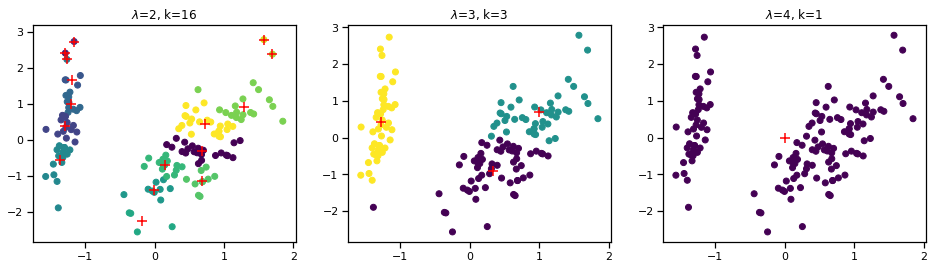

In [32]:
x,y = X_pca.T
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i,c in enumerate([2, 3, 4]):
    dpm = dp_means(X_pca, c, metric='seuclidean')
    axes[i].scatter(x, y, c=dpm['z'])
    axes[i].scatter(*dpm['centers'].T, c='r', marker='+', s=100)
    axes[i].set_title(r'$\lambda$={0}, k={1}'.format(c, dpm['k']))

In [33]:
clusters = []
lambdas = np.linspace(2, 4)
for c in lambdas:
    dpm = dp_means(X_pca, c, metric='euclidean')
    clusters.append(len(dpm['centers']))

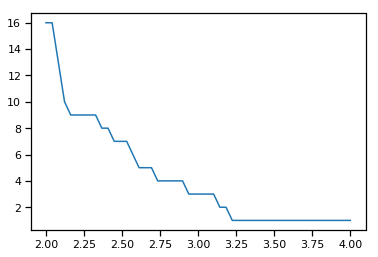

In [34]:
plt.plot(lambdas, clusters)

### Exercise: Wine clustering

Try running DP-means on the wine chemistry dataset. Try varying the value for `lam` to see where the number of clusters stabilizes.

Consider how might this be implemented using PyMC3?

In [35]:
# Write your answer here

## DBSCAN

Aside from issues with choosing the number of groups *a priori*, K-means has trouble identifying groups that are not spherical and convex.

In [36]:
from sklearn import datasets

points, labels = datasets.make_moons(n_samples=100, noise=.05)

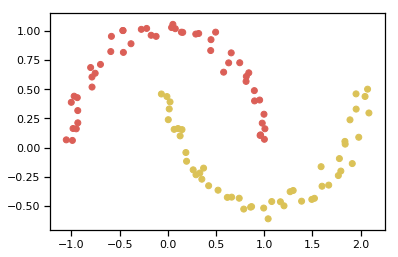

In [37]:
palette = np.array(sns.color_palette("hls", 8))

plt.scatter(*points.T, color=palette[labels])

In [38]:
moons = KMeans(n_clusters=2, random_state=rng)
moons.fit(points)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=<mtrand.RandomState object at 0x7f15939dfab0>, tol=0.0001,
    verbose=0)

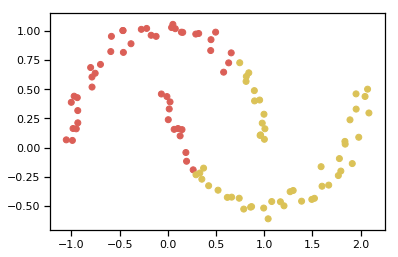

In [39]:
plt.scatter(*points.T, color=palette[moons.labels_])

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm, introduced [Ester et al. (1996)](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf).

DBSCAN infers the number of clusters from the dataset, allowing it to discover clusters of arbitrary shape. It establishes a **neighborhood size**, and assigns points to categories based on their relationship to other points, conditioned on this neighborhood size. 

This confers several advantages:

- Allows for more complex cluster shapes
- K does not need to be specified
- Automatically finds outliers

While we don't need to choose K, we do need to select a distance function for quantifying **dissimilarity** between points.



2. Connect core points into clusters

3. Assign boundary points to clusters

The steps to the DBSCAN algorithm are:

1. **Determine the type of a new point**

    - core
    - boundary
    - outlier

  We randomly pick that has not yet been assigned to a cluster, or been designated as an outlier. For this point, we determine its neighborhood. If it is a **core point**, we seed a cluster around it, otherwise label the point as an **outlier**.

2. **Expand the new cluster by adding all reachable points**. Once we find a core point (and hence, a cluster), find all points that are reachable based in the neighborhood and add them to the cluster. If a point previously found to be an outlier is included, change its status to a **border point**.

3. Repeat these steps until all points are either assigned to a cluster or designated as an outlier.

The `DBSCAN` class in `scikit-learn` is a straightforward implementation of this algorithm, and requires three main arguments:

- `eps` defines the size of the neighborhood around each point

- `min_samples` is the number of points that needs to be within the neigborhood for a point to be considered a core point; density level threshold

- `metric` is either a callable function or a string corresponding to a built-in distance metric


In [40]:
from sklearn.cluster import DBSCAN

dbscan_moons = DBSCAN(eps=0.4, min_samples=11)
dbscan_moons.fit(points)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=11, n_jobs=1, p=None)

In [41]:
dbscan_moons.labels_

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

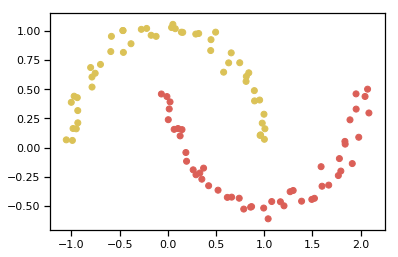

In [42]:
plt.scatter(*points.T, color=palette[dbscan_moons.labels_])

---
## References

1. Kulis B and Jordan MI. Revisiting k-means: New Algorithms via Bayesian Nonparametrics. arXiv preprint [arXiv:11110352](http://arxiv.org/abs/1111.0352) 2011.
2. Ester, M., H. P. Kriegel, J. Sander, and X. Xu, “A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise”. In: Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, Portland, OR, AAAI Press, pp. 226-231. 1996